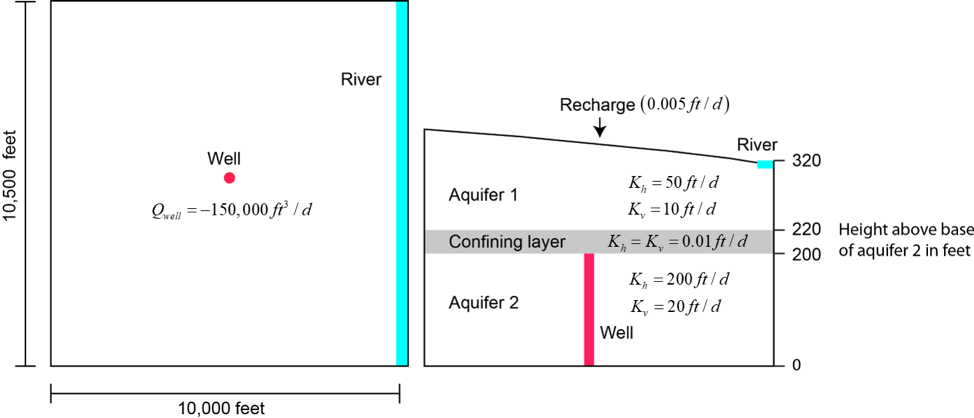

# 02: Building and post-processing a MODFLOW 6 model

A MODFLOW 6 model will be developed of the domain shown above. This model simulation is based on example 1 in [Pollock, D.W., 2016, User guide for MODPATH Version 7—A particle-tracking model for MODFLOW: U.S. Geological Survey Open-File Report 2016–1086, 35 p., http://dx.doi.org/10.3133/ofr20161086](https://doi.org/10.3133/ofr20161086).

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500 ft will be specified for `delr` and `delc`. The top (`TOP`) of the model should be set to 400 ft and the bottom of the three layers should be set to 220 ft, 200 ft, and 0 ft, respectively. The model has one steady-state stress period. 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
from flopy.plot import styles

Before we get started lets install MODFLOW 6, other MODFLOW-based executables (MODFLOW-2005, MT3DMS, _etc._), and utilities programs used by FloPy (gridgen and triangle) in the Miniforge class environment (`pyclass`) using FloPy `get-modflow` functionality (`flopy.utils.get_modflow()`). Remember that `Shift-Tab` can be used to see the `docstrings` for a Python function, method, or function. Press `Shift-Tab` after the opening parenthesis in `flopy.utils.get_modflow()` below to see the `docstrings` for the function and determine the required (`args`) and optional arguments (`kwaargs`).

In [2]:
flopy.utils.get_modflow(":python")

auto-selecting option ':python' for 'bindir'
fetched release '18.0' info from MODFLOW-USGS/executables
downloading 'https://github.com/MODFLOW-USGS/executables/releases/download/18.0/linux.zip' to '/tmp/tmpc6avsc3b/modflow_executables-18.0-linux.zip'


extracting 26 files to '/home/runner/micromamba/envs/pyclass-docs/bin'


crt (1.3.1)         mf6 (6.4.4)         mfusg_gsi (2.2.2)   triangle (1.6)
gridgen (1.0.02)    mflgr (2.0.0)       mp6 (6.0.1)         vs2dt (3.3)
gsflow (2.2.1)      mflgrdbl (2.0.0)    mp7 (7.2.001)       zbud6 (6.4.4)
libmf6.so (6.4.4)   mfnwt (1.3.0)       mt3dms (5.3.0)      zonbud3 (3.01)
mf2000 (1.19.01)    mfnwtdbl (1.3.0)    mt3dusgs (1.1.0)    zonbudusg (1.5)
mf2005 (1.12.00)    mfusg (1.5)         sutra (3.0)
mf2005dbl (1.12.00) mfusgdbl (1.5)      swtv4 (4.00.05)
wrote new flopy metadata file: '/home/runner/.local/share/flopy/get_modflow.json'


Before creating any of the MODFLOW 6 FloPy objects you should define the simulation workspace (`ws`) where the model files are and the simulation name (`name`). The `ws` should be set to `'data/ex01b'` and `name` should be set to `ex01b`.

In [3]:
ws = "../temp/ex01b"
name = "ex01b"

Create a simulation object, a temporal discretization object, and a iterative model solution object using `flopy.mf6.MFSimulation()`, `flopy.mf6.ModflowTdis()`, and `flopy.mf6.ModflowIms()`, respectively. Set the `sim_name` to `name` and `sim_ws` to `ws` in the simulation object. Use default values for all temporal discretization and iterative model solution variables. Make sure to include the simulation object (`sim`) as the first variable in the temporal discretization and iterative model solution objects.

In [4]:
# create simulation (sim = flopy.mf6.MFSimulation())
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws)

# create tdis package (tdis = flopy.mf6.ModflowTdis(sim))
tdis = flopy.mf6.ModflowTdis(sim)

# create iterative model solution (ims = flopy.mf6.ModflowIms(sim))
ims = flopy.mf6.ModflowIms(sim)

Create the groundwater flow model object (`gwf`) using `flopy.mf6.ModflowGwf()`. Make sure to include the simulation object (`sim`) as the first variable in the groundwater flow model object and set `modelname` to `name`. Use `Shift-Tab` to see the optional variables that can be specified.

In [5]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

Create the discretization package using `flopy.mf6.ModflowGwfdis()`. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `DIS` package (`flopy.mf6.ModflowGwfdis()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-dis.html).

FloPy can accomodate all of the options for specifying array data for a model. `CONSTANT` values for a variable can be specified by using a `float` or `int` python variable (as is done below for `DELR`, `DELC`, and `TOP`). `LAYERED` data can be specified by using a list or `CONSTANT` values for each layer (as is done below for `BOTM` data) or a list of numpy arrays or lists. Three-Dimensional data can be specified using a three-dimensional numpy array (with a shape of `(nlay, nrow, ncol)`) for this example. More information on how to specify array data can be found in the [FloPy ReadTheDocs](https://flopy.readthedocs.io/en/latest/Notebooks/mf6_data_tutorial07.html#MODFLOW-6:-Working-with-MODFLOW-Grid-Array-Data). 

In [6]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220, 200, 0]

In [7]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

`flopy.plot.PlotMapView()` and `flopy.plot.PlotCrossSection()` can be used to confirm that the discretization is correctly defined.

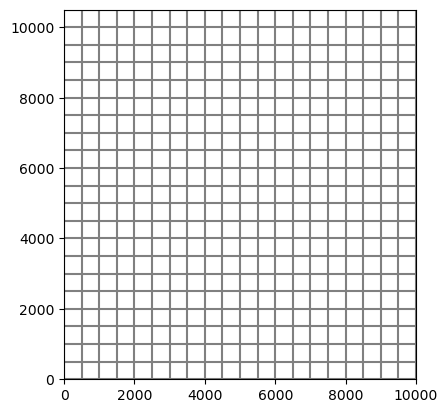

In [8]:
mm = flopy.plot.PlotMapView(model=gwf)
mm.plot_grid()

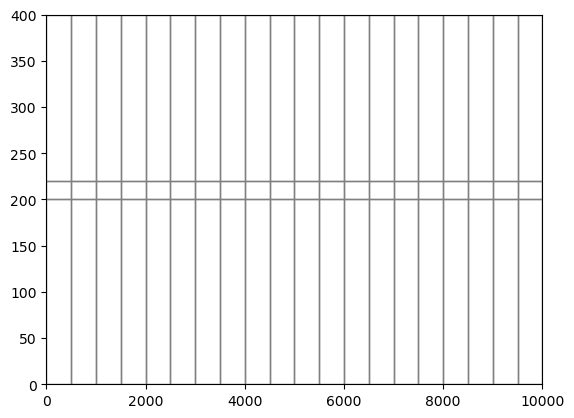

In [9]:
xs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 10})
xs.plot_grid()

#### Create the initial conditions (IC) package

Create the initial conditions package (`IC`) using `flopy.mf6.ModflowGwfic()` and set the initial head (`strt`) to 320. Default values can be used for the rest of the initial conditions package input. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `IC` package (`flopy.mf6.ModflowGwfic()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-ic.html).

In [10]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=320.0)

#### Create the node property flow (NPF) package

The hydraulic properties for the model are defined in the image above and are specified in the node property flow package (`NPF`) using `flopy.mf6.ModflowGwfnpf()`. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so `icelltype` should be `[1, 0, 0]`. The variable `save_specific_discharge` should be set to `True` so that specific discharge data are saved to the cell-by-cell file and can be used to plot discharge. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `NPF` package (`flopy.mf6.ModflowGwfic()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-npf.html).

In [11]:
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
icelltype = [1, 0, 0]

In [12]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf, save_specific_discharge=True, icelltype=icelltype, k=kh, k33=kv
)

#### Create the recharge package

The recharge rate is defined in the image above. Use the `flopy.mf6.ModflowGwfrcha()` method to specify recharge data using arrays. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `RCH` package (`flopy.mf6.ModflowGwfrcha()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-rcha.html).

In [13]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005)

#### Create the well package

The well is located in layer 3, row 11, column 10. The pumping rate is defined in the image above. Use the `flopy.mf6.ModflowGwfwel()` method to specify well data for the well package (`WEL`). Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `WEL` package (`flopy.mf6.ModflowGwfwel()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-wel.html).

`stress_period_data` for list-based stress packages (for example, `WEL`, `DRN`, `RIV`, and `GHB`) is specified as a dictionary with the zero-based stress-period number as the key and a list of tuples, with the tuple containing the data required for each stress entry. For example, each tuple for the `WEL` package includes a zero-based cellid and the well rate `(cellid, q)`. For this example, the zero-based cellid for `WEL` package can be a tuple with the `(layer, row, column)` for the well or three integers separated by a comma `layer, row, column`. More information on how to specify `stress_period_data` for list based stress packages can be found in the [FloPy ReadTheDocs](https://flopy.readthedocs.io/en/latest/Notebooks/mf6_data_tutorial06.html#Adding-Stress-Period-List-Data). 

An example of a `stress_period_data` tuple for the `WEL` package is

```python
# (layer, row, column, q)
(0, 0, 0, -1e5)
```

In [14]:
wel_spd = {0: [[(2, 10, 9), -150000]]}
wel = flopy.mf6.ModflowGwfwel(
    gwf, print_input=True, stress_period_data=wel_spd
)

#### Create the river package

The river is located in layer 1 and column 20 in every row in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5. Use the `flopy.mf6.ModflowGwfriv()` method to specify well data for the river package (`RIV`). Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `RIV` package (`flopy.mf6.ModflowGwfriv()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-riv.html).

An example of a `stress_period_data` tuple for the `RIV` package is

```python
# (layer, row, column, stage, cond, rbot)
(0, 0, 0, 320., 1e5, 318.)
```

**HINT**: list comprehension is an easy way to create a river cell in every row in column 20 of the model.

In [15]:
riv_spd = {0: [((0, i, 19), 320, 1e5, 318) for i in range(nrow)]}
riv_spd

{0: [((0, 0, 19), 320, 100000.0, 318),
  ((0, 1, 19), 320, 100000.0, 318),
  ((0, 2, 19), 320, 100000.0, 318),
  ((0, 3, 19), 320, 100000.0, 318),
  ((0, 4, 19), 320, 100000.0, 318),
  ((0, 5, 19), 320, 100000.0, 318),
  ((0, 6, 19), 320, 100000.0, 318),
  ((0, 7, 19), 320, 100000.0, 318),
  ((0, 8, 19), 320, 100000.0, 318),
  ((0, 9, 19), 320, 100000.0, 318),
  ((0, 10, 19), 320, 100000.0, 318),
  ((0, 11, 19), 320, 100000.0, 318),
  ((0, 12, 19), 320, 100000.0, 318),
  ((0, 13, 19), 320, 100000.0, 318),
  ((0, 14, 19), 320, 100000.0, 318),
  ((0, 15, 19), 320, 100000.0, 318),
  ((0, 16, 19), 320, 100000.0, 318),
  ((0, 17, 19), 320, 100000.0, 318),
  ((0, 18, 19), 320, 100000.0, 318),
  ((0, 19, 19), 320, 100000.0, 318),
  ((0, 20, 19), 320, 100000.0, 318)]}

In [16]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

#### Build output control

Define the output control package (`OC`) for the model using the `flopy.mf6.ModflowGwfoc()` method to `[('HEAD', 'ALL'), ('BUDGET', 'ALL')]` to save the head and flow for the model. Also the head (`head_filerecord`) and cell-by-cell flow (`budget_filerecord`) files should be set to `f"{name}.hds"` and `f"{name}.cbc"`, respectively. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `OC` package (`flopy.mf6.ModflowGwfoc()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-oc.html).

In [17]:
hname = f"{name}.hds"
cname = f"{name}.cbc"
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=cname,
    head_filerecord=hname,
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

Because we haven't set `SAVE_FLOWS` to `True` in all of the packages we can set `.name_file.save_flows` to `True` for the groundwater flow model (`gwf`) to save flows for all packages that can save flows. 

In [18]:
gwf.name_file.save_flows = True

#### Write the model files and run the model

Write the MODFLOW 6 model files using `sim.write_simulation()`. Use `Shift-Tab` to see the optional variables that can be specified for `.write_simulation()`.

In [19]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex01b...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...


Run the model using `sim.run_simulation()`, which will run the MODFLOW 6 executable installed in the Miniforge class environment (`pyclass`) and the MODFLOW 6 model files created with `.write_simulation()`. Use `Shift-Tab` to see the optional variables that can be specified for `.run_simulation()`.

In [20]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../../../../micromamba/envs/pyclass-docs/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 19 2024 14:19:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that n

(True, [])

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `gwf.output.head()` method. The cell-by-cell file can be loaded with the `gwf.output.budget()` method. 

Name the heads data `hds`.

In [21]:
hobj = gwf.output.head()

In [22]:
hds = hobj.get_data()

In [23]:
cobj = gwf.output.budget()

The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [24]:
cobj.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
WEL                  6
RIV                  6
RCHA                 6


Retrieve the `'DATA-SPDIS'` data type from the cell-by-cell file. Name the specific discharge data `spd`.

Cell-by-cell data is returned as a list so access the data by using `spd = gwf.output.budget().get_data(text="DATA-SPDIS")[0]`.

In [25]:
spd = cobj.get_data(text="DATA-SPDIS")[0]

#### Plot the results

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_specific_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

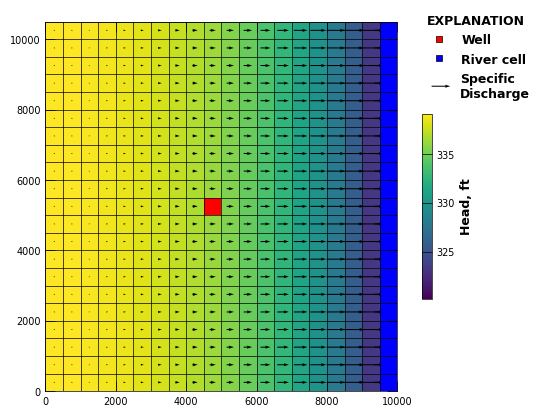

In [26]:
with styles.USGSMap():
    mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)
    cbv = mm.plot_array(hds)
    q = mm.plot_vector(spd["qx"], spd["qy"])
    mm.plot_bc("RIV", color="blue")
    mm.plot_bc("WEL", plotAll=True)
    mm.plot_grid(lw=0.5, color="black")

    # create data outside of plot limits for legend data
    font_prop = mpl.font_manager.FontProperties(size=9, weight="bold")
    mm.ax.plot(-100, -100, marker="s", lw=0, ms=4, mfc="red", mec="black", mew=0.5, label="Well")
    mm.ax.plot(-100, -100, marker="s", lw=0, ms=4, mfc="blue", mec="black", mew=0.5, label="River cell")
    
    # plot legend
    styles.graph_legend(bbox_to_anchor=(1.05, 1.05))
    plt.quiverkey(q, X = 1.15, Y = 0.825, U = .200, label ='Specific\nDischarge', labelpos="E", fontproperties=font_prop) 

    # plot colorbar
    cb = plt.colorbar(cbv, ax=mm.ax, shrink=0.5)
    cb.set_label(label="Head, ft", weight="bold")
    